### Summarize machine learning results and plot in R

An experiment was done to compare convolutional neural networks (CNNs) with traditional machine learning techniques for a large image classification task. This notebook reads the results, computes some summary statistics, and plots the summary.

R's ggplot2 library is used for plotting.

In [1]:
import warnings; warnings.simplefilter('ignore')
%load_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import os

DIR = '/home/joefutrelle/data/ifcb-cnn'
assert os.path.exists(DIR)

Here we define functions for reading the [confusion matrices](https://en.wikipedia.org/wiki/Confusion_matrix) and computing the [F1 score](https://en.wikipedia.org/wiki/F1_score) for each classifer for each class.

In [3]:
def read_cm(kind, n_classes=49, features_version=3):
    fn = 'cm_{}_{}_v{}.csv'.format(kind, n_classes, features_version)
    path = os.path.join(DIR, fn)
    return pd.read_csv(path, index_col=0)

def read_cnn_cm(ft):
    path = os.path.join(DIR, 'cm_cnn_49_{}.csv'.format(ft))
    return pd.read_csv(path, index_col=0)

def summarize_confusion_matrix(cm):
    total = cm.sum(axis=1)
    true_positive = np.diag(cm)
    false_positive = total - true_positive
    false_negative = cm.sum(axis=0) - true_positive
    true_negative = total.sum() - true_positive - false_negative - false_positive
    precision = true_positive / (true_positive + false_positive)
    recall = true_positive / (true_positive + false_negative)
    f1 = 2 * (precision * recall) / (precision + recall)
    pr = pd.DataFrame(dict(precision=precision, recall=recall, f1=f1),
                      columns=['precision','recall','f1'])
    return pr

Five methods were evaluated. Summarize the confusion matrix of each one:

In [4]:
features_version = 3
n_classes = len(read_cnn_cm('full').index)

rf_pr = summarize_confusion_matrix(read_cm('rf',n_classes,features_version))
nn_pr = summarize_confusion_matrix(read_cm('nn',n_classes,features_version))
svm_pr = summarize_confusion_matrix(read_cm('svm',n_classes,features_version))
cnn_full_pr = summarize_confusion_matrix(read_cnn_cm('full'))
cnn_transfer_pr = summarize_confusion_matrix(read_cnn_cm('transfer'))

rf_label = 'Random Forest'
mlp_label = 'MLP Neural Network'
svm_label = 'Support Vector Machines'
cnn_full_label = 'CNN (full)'
cnn_transfer_label = 'CNN (transfer)'

Reorganize the resulting summary into a Pandas dataframe where there is a row for each method/class pair, holding the F1 score

In [5]:
# make a tidy dataframe where one column is method and one column is for each class's f1 score
from functools import reduce

dfs = []

for method, pr in [(rf_label, rf_pr),
                   (mlp_label, nn_pr),
                   (svm_label, svm_pr),
                   (cnn_full_label, cnn_full_pr),
                   (cnn_transfer_label, cnn_transfer_pr)]:
    dfs.append(pd.DataFrame({'method': method, 'f1': pr['f1'] }))
    
df = reduce(lambda a,b: a.append(b), dfs)
df.head()

,method,f1
Asterionellopsis,Random Forest,0.830918
Balanion_sp,Random Forest,0.511364
Cerataulina,Random Forest,0.660342
Chaetoceros,Random Forest,0.629356
Chaetoceros_didymus_flagellate,Random Forest,0.867384


Now use R to make a violin plot of the results

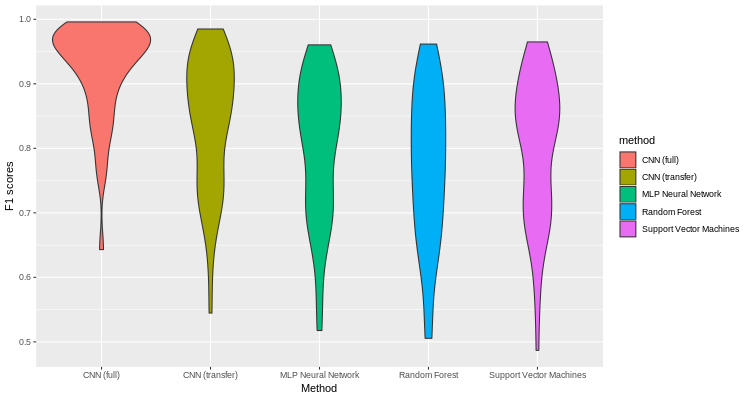

In [6]:
%%R -i df -w 750 -h 400

library(ggplot2)

# Create a Violin plot
ggplot(df, aes(x = method, y = f1, fill = method)) + 
  geom_violin() +
  labs(x = "Method", y = "F1 scores")